# Loki2 Morphology-to-Transcriptome Retrieval

This notebook demonstrates how to retrieve transcriptomic profiles from Loki2 cell morphological features using cross-modal contrastive learning.

## Data Requirements

The example data is stored in the directory `../data/morph_retrieve`, which can be donwloaded from [Google Drive](https://drive.google.com/drive/folders/19qzd8jTZBQ57a3N5xbiZFSGZJNpIz8NQ?usp=sharing).

You will need:
- Paired morphology-transcriptome data for training
- Single-cell RNA-seq reference atlas
- H&E image to retrieve transcriptome data
- OmiCLIP model checkpoint for transcriptome encoding

## Prepare Training Data

Extract transcriptomic embeddings using OmiCLIP and pair them with morphological embeddings from Loki2. This creates paired training data that links morphological features to transcriptomic profiles. The data is organized into shards for efficient training with WebDataset format.

Please follow [Loki Notebooks](https://guangyuwanglab2021.github.io/Loki/) to creat the conda enveriment `loki_env` for contrastive learning. \
Please put the [OmiCLIP checkpoint](https://huggingface.co/WangGuangyuLab/Loki) `omiclip.pt` to `../src/loki2/`.

```bash
conda activate loki_env

DATA_PATH="../data/morph_retrieve/P1CRC_VISIUMHD_LOKI2_mask.h5ad"
OUTPUT="../outputs/morph_retrieve/output/P1CRC_cell_trans_emb_raw.pt"

python ../src/loki2/encode_trans.py "$DATA_PATH" \
    --output "$OUTPUT" \
    --batch-size 1024 \
    --num-threads 32 \
    --device cuda

python ../src/loki2/cl/prepare_training.py \
    --dataset-name P1CRC \
    --trans-path "$OUTPUT" \
    --morph-path ../data/morph_retrieve/P1CRC_cell_morph_emb.pt \
    --output-dir ../outputs/morph_retrieve/output/P1CRC_train \
    --shard-size 10000
```

## Training

Train a neural network projection model using contrastive learning to align morphological and transcriptomic embedding spaces. The model learns to project embeddings from both modalities into a shared space where similar cells from different modalities are close together. This enables cross-modal retrieval between morphology and transcriptome.

```bash
conda activate loki_env

DATASET="${DATASET:-P1CRC}"
RUN_NAME="${RUN_NAME:-${DATASET}_wds_vanilla}"
RUN_DIR="../outputs/morph_retrieve/output/runs/${RUN_NAME}"

TRAIN_DIR="../outputs/morph_retrieve/output/P1CRC_train/${DATASET}/train"
VAL_DIR="../outputs/morph_retrieve/output/P1CRC_train/${DATASET}/val"
TRAIN_META="${TRAIN_DIR}/manifest_train.csv"
VAL_META="${VAL_DIR}/manifest_val.csv"

if [[ ! -f "${TRAIN_META}" ]]; then
  echo "Missing train manifest: ${TRAIN_META}" >&2
  exit 1
fi

if [[ ! -f "${VAL_META}" ]]; then
  echo "Missing validation manifest: ${VAL_META}" >&2
  exit 1
fi

mapfile -t TRAIN_SHARDS < <(find "${TRAIN_DIR}" -maxdepth 1 -type f -name 'shard-*.tar' | sort)
mapfile -t VAL_SHARDS < <(find "${VAL_DIR}" -maxdepth 1 -type f -name 'shard-*.tar' | sort)

if [[ ${#TRAIN_SHARDS[@]} -eq 0 ]]; then
  echo "No training shards found in ${TRAIN_DIR}" >&2
  exit 1
fi

if [[ ${#VAL_SHARDS[@]} -eq 0 ]]; then
  echo "No validation shards found in ${VAL_DIR}" >&2
  exit 1
fi

TRAIN_SHARD_LIST=$(IFS=, ; echo "${TRAIN_SHARDS[*]}")
VAL_SHARD_LIST=$(IFS=, ; echo "${VAL_SHARDS[*]}")

mkdir -p "${RUN_DIR}"

python ../src/loki2/cl/train_projection_wds.py \
  --train-shards "${TRAIN_SHARD_LIST}" \
  --train-meta "${TRAIN_META}" \
  --val-shards "${VAL_SHARD_LIST}" \
  --val-meta "${VAL_META}" \
  --num-layers 1 \
  --batch-size 4096 \
  --epochs 20 \
  --lr 5e-4 \
  --device cuda \
  --amp \
  --save-every 1 \
  --output-dir "${RUN_DIR}" \
  --log-file train.log
```

## Retrieve from scRNA Data

Encode single-cell RNA-seq reference data and project both morphological and transcriptomic embeddings into the shared space. Then use nearest neighbor search to retrieve matching transcriptomic profiles for spatial cells based on their morphological features. This enables cell type transfer from scRNA-seq to spatial data and gene expression prediction from morphology.

```bash
conda activate loki_env

sam="CRC_sc"
DATA_PATH="../data/morph_retrieve/CRC_sc.h5ad"
OUTPUT="../outputs/morph_retrieve/output/${sam}_trans.pt"

python ../src/loki2/encode_trans.py "$DATA_PATH" \
    --output "$OUTPUT" \
    --batch-size 1024 \
    --num-threads 32 \
    --device cuda
```

```bash
conda deactivate
conda activate loki2_env

CHECKPOINT_DIR="../outputs/morph_retrieve/output/runs/P1CRC_wds_vanilla"

# Set the epoch to use for projection (default: 20)
EPOCH=${EPOCH:-20}
CKPT_PATH="${CHECKPOINT_DIR}/projection_cl_epoch${EPOCH}.pt"

if [[ ! -f "${CKPT_PATH}" ]]; then
  echo "Checkpoint not found: ${CKPT_PATH}" >&2
  exit 1
fi

declare -A SAMPLE_MAP=(
  ["Cancer_P2"]="P2CRC"
)

for label in Cancer_P2; do
  dataset="${SAMPLE_MAP[$label]}"
  morph_path="../data/morph_retrieve/${SAMPLE_MAP[$label]}_cell_morph_emb.pt"
  output_dir="../outputs/morph_retrieve/output/data_projection/${dataset}"

  if [[ ! -f "${morph_path}" ]]; then
    echo "Skipping ${label}: missing morphology embeddings at ${morph_path}" >&2
    continue
  fi

  echo "Projecting ${label} (dataset: ${dataset})"
  mkdir -p "${output_dir}"

  python ../src/loki2/cl/project_raw_embeddings.py \
    --checkpoint "${CKPT_PATH}" \
    --morph-path "${morph_path}" \
    --modality morph \
    --batch-size 4096 \
    --normalized \
    --tag "${label}_epoch${EPOCH}" \
    --output-dir "${output_dir}"
done

TRANS_PATH="../outputs/morph_retrieve/output/CRC_sc_trans.pt"
OUTPUT_DIR="../outputs/morph_retrieve/output/data_projection/sc"

if [[ ! -f "${TRANS_PATH}" ]]; then
  echo "Transcription embeddings missing: ${TRANS_PATH}" >&2
  exit 1
fi

mkdir -p "${OUTPUT_DIR}"

python ../src/loki2/cl/project_raw_embeddings.py \
  --checkpoint "${CKPT_PATH}" \
  --trans-path "${TRANS_PATH}" \
  --modality trans \
  --batch-size 4096 \
  --normalized \
  --tag "epoch${EPOCH}" \
  --output-dir "${OUTPUT_DIR}"

declare -A SAMPLE_MAP=(
  ["Cancer_P2"]="P2CRC"
)

for label in "${!SAMPLE_MAP[@]}"; do
    dataset="${SAMPLE_MAP[$label]}"
    output_dir=${3:-"../outputs/morph_retrieve/output/result_centroid/retrieve_epoch${EPOCH}"}
    mkdir -p ${output_dir}
    echo "Processing sample: ${dataset}, output directory: ${output_dir}"
    python ../src/loki2/retrieve_from_sc.py ${dataset} ${label} ${EPOCH} ${output_dir}
done
```

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import loki2.retrieve
import loki2.plot

## Load Retrieval Results

Load the projected embeddings and retrieval results. The retrieval results contain indices of matching cells from the single-cell reference atlas and their similarity scores, which can be used to predict cell types and gene expression patterns.

In [2]:
sample_name = "P2CRC"
proj_path = "../outputs/morph_retrieve/output/data_projection/P2CRC/morph_proj_Cancer_P2_epoch20.npz"
result_dir = "../outputs/morph_retrieve/output/result_centroid/retrieve_epoch20"
celltype_path = f"{result_dir}/cell_type_assignments_{sample_name}.csv"
result_path = f"{result_dir}/retr_from_atlas_{sample_name}.pt"

In [3]:
data_morph = np.load(proj_path, allow_pickle=True)
list(data_morph.keys())

['row_index', 'cell_id', 'positions', 'morph_proj', 'morph_proj_norm']

In [4]:
celltype_df = pd.read_csv(celltype_path, index_col=0)
result = torch.load(result_path)
indices = result['indices']
values = result['scores']

In [5]:
sc_ad = sc.read_h5ad("../data/morph_retrieve/CRC_sc.h5ad")
sc_ad.obsm['X_umap'] = sc_ad.obs[['UMAP1', 'UMAP2']].values
sc_ad

AnnData object with n_obs × n_vars = 260506 × 18082
    obs: 'Patient', 'BC', 'QCFilter', 'Level1', 'Level2', 'UMAP1', 'UMAP2'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_umap'

In [6]:
source_labels = sc_ad.obs['Level1']
level1_retrieved_top1 = source_labels.iloc[indices[:, 0]]
preds, _ = loki2.retrieve.knn_majority_vote(indices, source_labels)
preds_w, counts = loki2.retrieve.knn_majority_vote(indices, source_labels, scores=values)
preds_t, _ = loki2.retrieve.knn_majority_vote(indices, source_labels, scores=values, temperature=0.07)

## Plot scRNA Data

Visualize the single-cell RNA-seq reference atlas in UMAP space, colored by cell type annotations. This provides context for understanding the reference data used for retrieval.

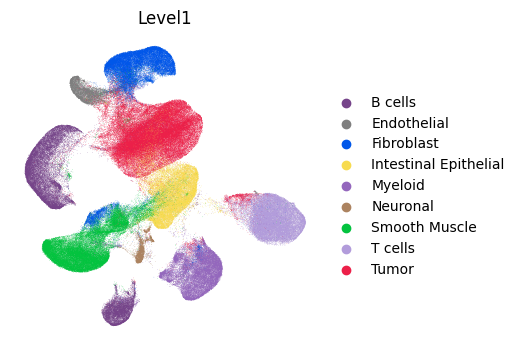

In [7]:
# ensure the category order matches your desired mapping
sc_ad.obs['Level1'] = sc_ad.obs['Level1'].astype('category')
# apply the colors to the categories
sc_ad.uns['Level1_colors'] = [loki2.plot.SC_COLOR_DICT[c] for c in sc_ad.obs['Level1'].cat.categories]
# plot
sc.pl.umap(sc_ad, color='Level1', frameon=False)

## Plot Loki2 Retrieval Results

Visualize the retrieved cell types and gene expression patterns mapped onto the spatial tissue coordinates.

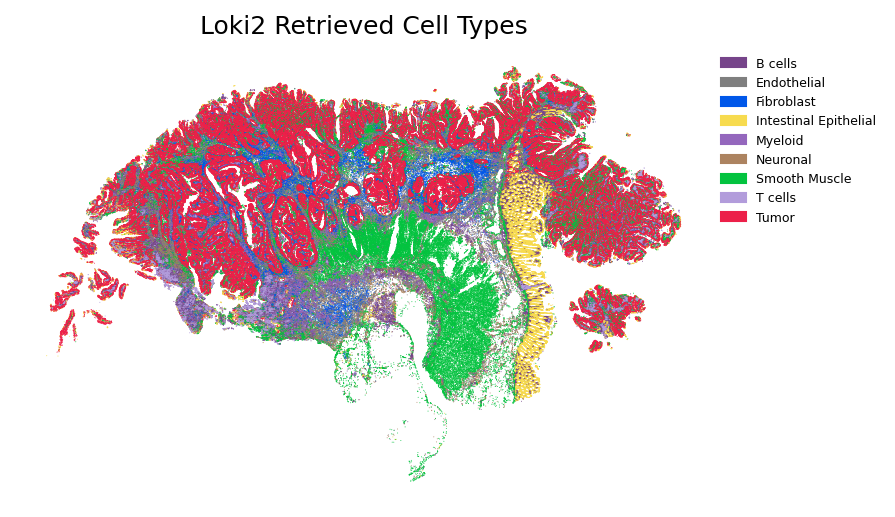

In [8]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(data_morph['positions'][:, 0], data_morph['positions'][:, 1], 
            c=loki2.plot.labels_to_hex(preds_t, loki2.plot.SC_COLOR_DICT), 
            s=0.2, edgecolors='none', linewidths=0)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.title("Loki2 Retrieved Cell Types")
plt.axis("off")

# -------- Legend --------
unique_classes = np.unique(preds_t)

handles = []
for cls in unique_classes:
    color = loki2.plot.SC_COLOR_DICT.get(cls, "#000000")  # fallback color if missing
    label = cls
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)

plt.legend(
    handles=handles,
    loc="upper right",
    fontsize=6,
    frameon=False,
    bbox_to_anchor=(1.25, 1.0)   # nudge legend outside the plot if needed
)

plt.show()

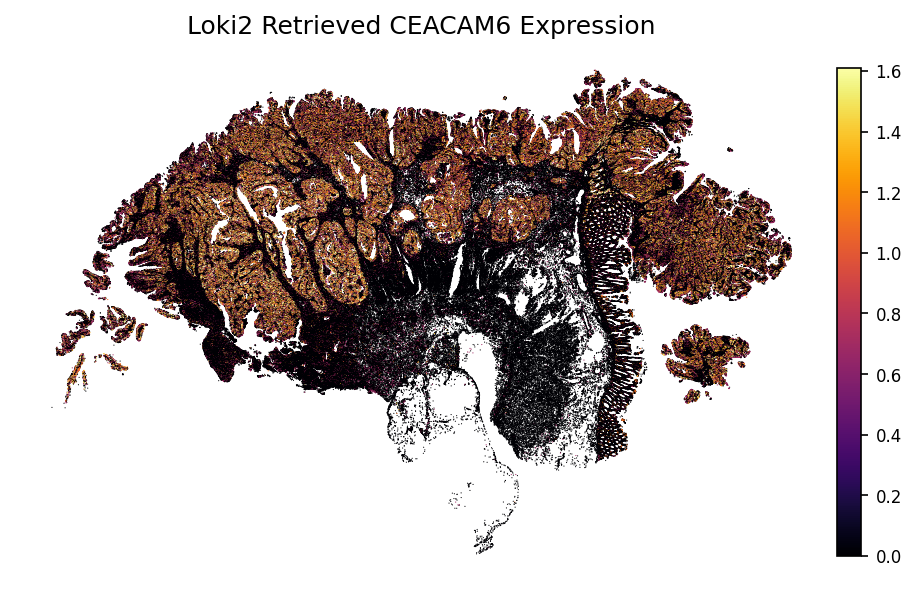

In [9]:
gene = 'CEACAM6'
loki2.plot.plot_gene(sc_ad, indices, data_morph, gene)

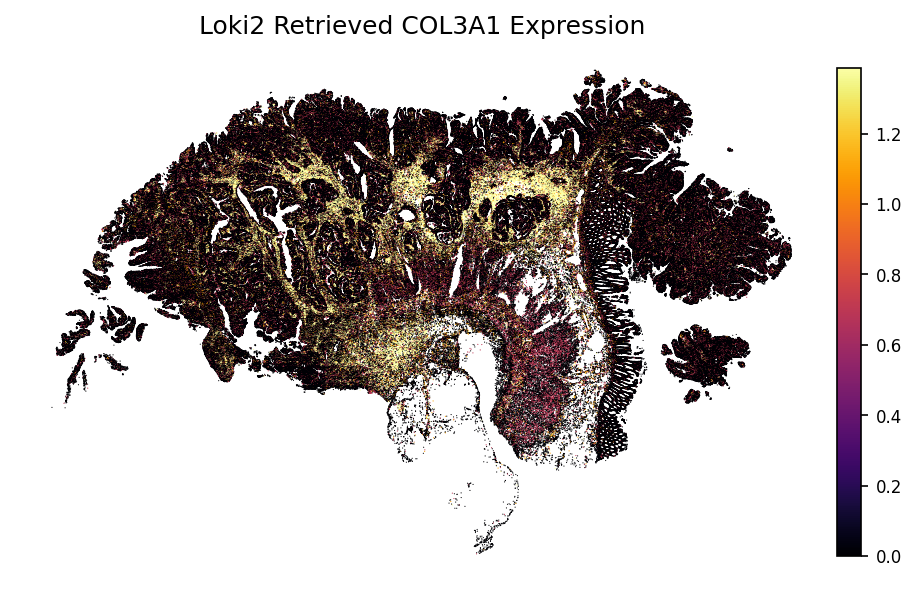

In [10]:
gene = 'COL3A1'
loki2.plot.plot_gene(sc_ad, indices, data_morph, gene)

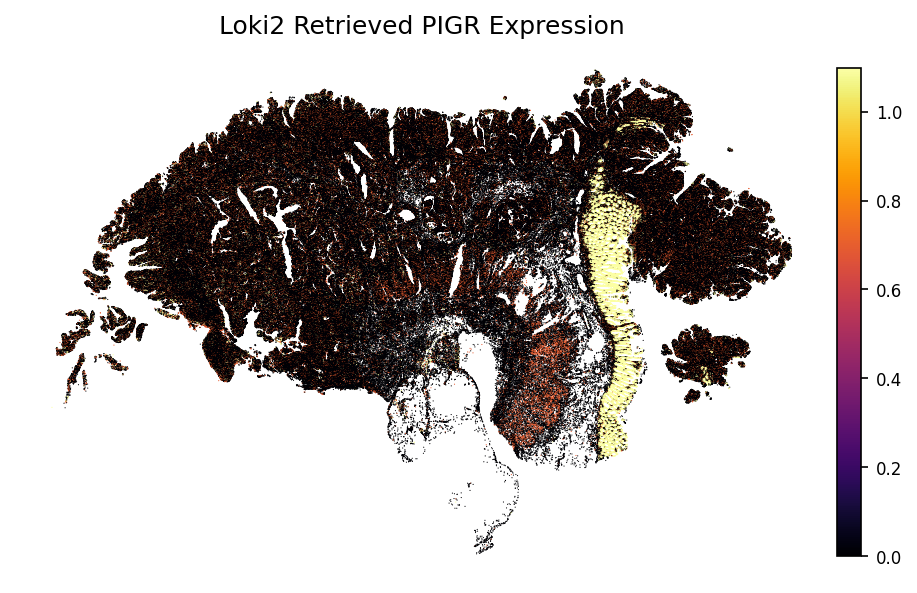

In [11]:
gene = 'PIGR'
loki2.plot.plot_gene(sc_ad, indices, data_morph, gene)